In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn import mixture
from scipy import linalg
import matplotlib as mpl
import itertools
from hmmlearn.hmm import GaussianHMM
import warnings
import pandas as pd
from sklearn.cross_validation import KFold
import seaborn as sns

warnings.filterwarnings('ignore')


/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


First the data is read and then the Gaussian HMM is calculated. The hidden states predicted are gathered.

In [3]:
full = pd.read_csv('full.csv', index_col=0)
full2 = pd.read_csv('full2.csv', index_col=0)
fullghmm = GaussianHMM(n_components = 2, n_iter=1000).fit(full['ADP'])
fullghmm2 = GaussianHMM(n_components = 2, n_iter=1000).fit(full2)
hidden_states = fullghmm.predict(full)
hidden_states2 = fullghmm2.predict(full2)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.0160602   0.02469895 -0.00671445 ...  0.00018918  0.01439865
  0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

Five fold cross validation is performed with various numbers of states:

In [3]:
n_states = [2, 3, 4, 5]
cv = KFold(full.shape[0], n_folds=5)
results = []
ghmml = []
for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [full.iloc[i] for i in train_index]
        test_data = [full.iloc[i] for i in test_index]
        ghmm = GaussianHMM(n_components = n, n_iter=1000).fit(train_data)
        train_score = ghmm.score(train_data)
        test_score = ghmm.score(test_data)
        ghmml.append(ghmm)
        results.append({
            'train_score': train_score,
            'test_score1': test_score,
            'n_states': n,
            #'p' : l,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))
print(avgs)

n_states = [2, 3, 4, 5]
cv = KFold(full2.shape[0], n_folds=5)
results = []
ghmml2 = []
for n in n_states:
    for fold, (train_index, test_index) in enumerate(cv):
        train_data = [full2.iloc[i] for i in train_index]
        test_data = [full2.iloc[i] for i in test_index]
        ghmm2 = GaussianHMM(n_components = n, n_iter=1000).fit(train_data)
        train_score = ghmm2.score(train_data)
        test_score = ghmm2.score(test_data)
        ghmml2.append(ghmm2)
        results.append({
            'train_score': train_score,
            'test_score2': test_score,
            'n_states': n,
            #'p' : l,
            'fold': fold})
           
results = pd.DataFrame(results)
avgs2 = (results
         .groupby('n_states')
         .aggregate(np.median)
         .drop('fold', axis=1))
print(avgs2)

            test_score1   train_score
n_states                             
2         659917.016021  2.542286e+06
3         663900.610987  2.562532e+06
4         668268.116258  2.581294e+06
5         668798.804260  2.592098e+06
            test_score2   train_score
n_states                             
2         681624.391730  2.803579e+06
3         692985.608165  2.844680e+06
4         696189.390621  2.895025e+06
5         705677.830531  2.923616e+06


The results from the 5-fold cross validation is analyzed through the usage of the AIC and BIC.

In [4]:
#del avgs['train_score']
#del avgs2['train_score']
temp=np.array(avgs.values.tolist())
l = full.shape[0]
aic=[]
bic=[]
for i in range(0,len(n_states)):

    a = -2 * temp[i] + 2 * n_states[i]
    b = -2 * temp[i] + (n_states[i]) * np.log(l)
    aic.append(a)
    bic.append(b)

df = pd.DataFrame({'AIC':aic[:], 'BIC':bic},index = ['2', '3', '4', '5'])
df['AIC'] = df['AIC'].str[0]
df['BIC'] = df['BIC'].str[0]
df.rename_axis('n_states')
print(df)
temp2=np.array(avgs2.values.tolist())
l = full.shape[0]
aic2=[]
bic2=[]
for i in range(0,len(n_states)):

    a = -2 * temp[i] + 2 * n_states[i]
    b = -2 * temp[i] + (n_states[i]) * np.log(l)
    aic2.append(a)
    bic2.append(b)

df2 = pd.DataFrame({'AIC':aic[:], 'BIC':bic},index = ['2', '3', '4', '5'])
df2['AIC'] = df2['AIC'].str[0]
df2['BIC'] = df2['BIC'].str[0]
df2.rename_axis('n_states')
print(df2)


            AIC           BIC
2 -1.319830e+06 -1.319817e+06
3 -1.327795e+06 -1.327776e+06
4 -1.336528e+06 -1.336502e+06
5 -1.337588e+06 -1.337555e+06
            AIC           BIC
2 -1.319830e+06 -1.319817e+06
3 -1.327795e+06 -1.327776e+06
4 -1.336528e+06 -1.336502e+06
5 -1.337588e+06 -1.337555e+06


Then the hidden states are analyzed and charted:

In [10]:
fig, axs = plt.subplots(fullghmm.n_components,figsize=(14,6), sharex=True, sharey=True)
colors = cm.Dark2(np.linspace(0, 1, fullghmm.n_components))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = hidden_states == i
    ax.plot(mask,".", markersize=.5, c=color)
    ax.set_title("Hidden State Number {0} - EM Data".format(i))
    ax.grid(True)
plt.show()

SyntaxError: invalid syntax (<ipython-input-10-16e600be61fa>, line 16)

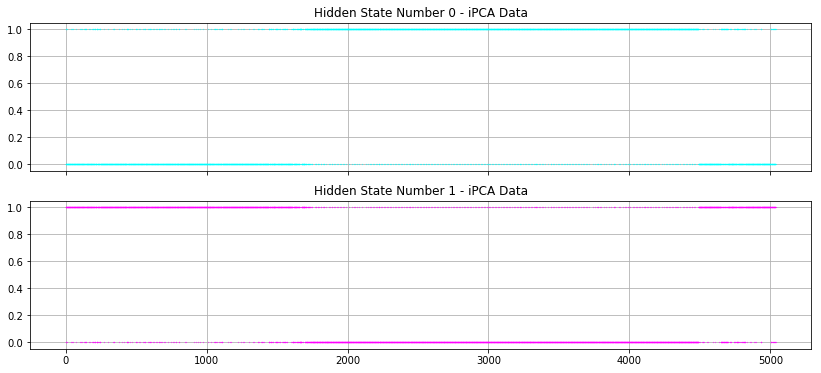

In [7]:
fig, axs = plt.subplots(fullghmm2.n_components,figsize=(14,6), sharex=True, sharey=True)
colors = cm.cool(np.linspace(0, 1, fullghmm2.n_components))
for i, (ax, color) in enumerate(zip(axs, colors)):
    mask = hidden_states2 == i
    ax.plot(mask,".", markersize=.5, c=color)
    ax.set_title("Hidden State Number {0} - iPCA Data".format(i))
    ax.grid(True)

plt.show()

The data for certain indexes are plotted according to the state they belong in:

Text(0.5,0.98,'Segmentation of Regimes - EM Data')

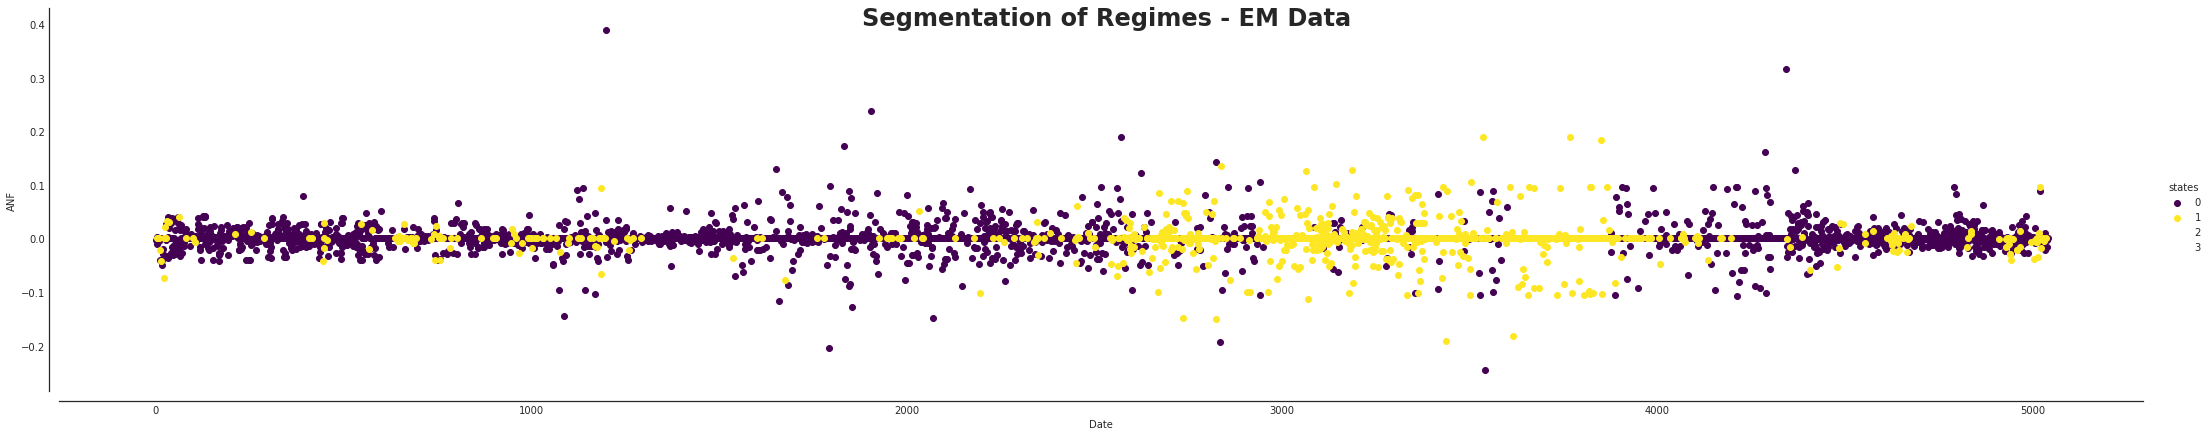

In [8]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, fullghmm.n_components)]
states = (pd.DataFrame(hidden_states, columns=['states'], index=full.index)
          .join(full, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
sns.set_style('white')
order = [0, 1, 2, 3]
states['mean'] = states._get_numeric_data().mean(axis=1)
fg = sns.FacetGrid(data=states, hue='states', hue_order=order,
                   palette=colors, aspect=5, size=6)
fg.map(plt.scatter, 'Date', 'ANF', alpha=1).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Segmentation of Regimes - EM Data', fontsize=24, fontweight='demi')

Text(0.5,0.98,'Segmentation of Regimes - iPCA Data')

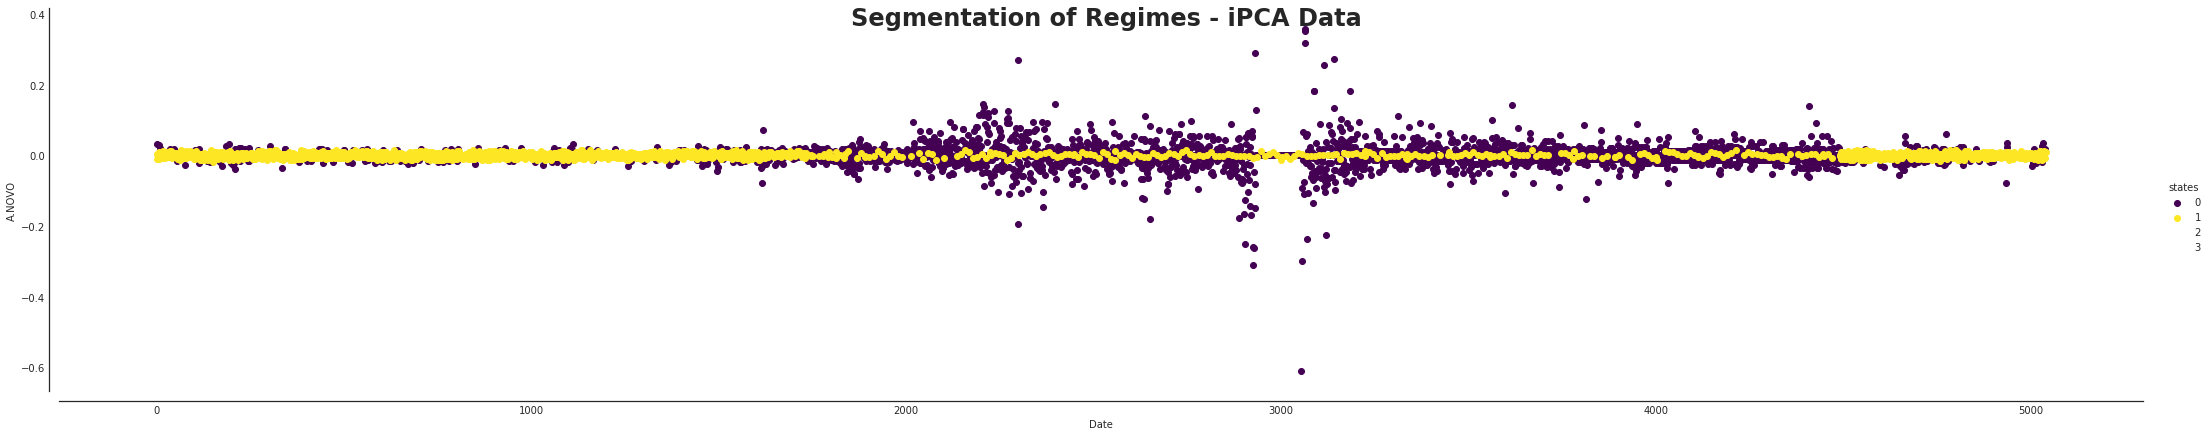

In [9]:
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, fullghmm2.n_components)]
states2 = (pd.DataFrame(hidden_states2, columns=['states'], index=full2.index)
          .join(full2, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
sns.set_style('white')
order = [0, 1, 2, 3]
states2['mean'] = states2._get_numeric_data().mean(axis=1)
fg = sns.FacetGrid(data=states2, hue='states', hue_order=order,
                   palette=colors, aspect=5, size=6)
fg.map(plt.scatter, 'Date', 'A.NOVO', alpha=1).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Segmentation of Regimes - iPCA Data', fontsize=24, fontweight='demi')


Here the predictive power of the HMM for predicting state classification is tested.

In [10]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full2, test_size = 0.6)
n_states = [2, 3, 4]
average_correct=[]
states_est_list = []
checktest = []
for n in n_states:
    ghmm3 = GaussianHMM(n_components = n, n_iter=1000).fit(train)
    state_sequence = ghmm3.predict(train) 
    #ghmmfull = GaussianHMM(n_components = 2, n_iter=1000).fit(full2)
    state_sequence_full = ghmm3.predict(test)
    posterior = ghmm3.predict_proba(train)
    states_estimated = []
    for i in range(0,test.shape[0]):
        prob_next_step = ghmm3.transmat_[state_sequence[-1], :]
        next_step=prob_next_step.argmax()
        states_estimated = np.append(states_estimated, next_step)
        state_sequence = np.append(state_sequence,next_step)
    average= np.sum(state_sequence[len(train):len(full2)] == state_sequence_full)/len(test)#[len(train):len(full2)])/len(test)
    average_correct = np.append(average_correct,average)
    #check = np.sum(state_sequence[0:len(train)] == state_sequence_full[0:len(train)])/len(train)
    #assurance = np.append(assurance,check)                      
    states_est_list = np.concatenate((states_est_list,states_estimated),axis=0)
    checktest = np.concatenate((checktest,state_sequence_full),axis=0)

checktest = np.asarray(np.array_split(checktest, 4))    
states_est_list = np.asarray(np.array_split(states_est_list, 4))

In [11]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(full2, test_size = 0.9)
average_correct=[]
states_est_list = []
checktest = []

ghmm3 = GaussianHMM(n_components = 4, n_iter=10000).fit(train)

In [12]:
ghmm3.monitor_
ghmm3.transmat_

array([[3.18376303e-01, 7.08763651e-02, 8.85475987e-02, 5.22199734e-01],
       [4.15670867e-01, 1.02087849e-01, 2.93337091e-04, 4.81947947e-01],
       [2.75828164e-01, 3.44997567e-02, 1.03449807e-01, 5.86222272e-01],
       [3.43359484e-01, 9.64178219e-02, 4.59380526e-02, 5.14284642e-01]])

In [15]:
state_sequence = ghmm3.predict(train) 
    #ghmmfull = GaussianHMM(n_components = 2, n_iter=1000).fit(full2)
state_sequence_full = ghmm3.predict(test)
states_estimated = []
posterior = ghmm3.predict_proba(train)[-1].T

for i in range(0,test.shape[0]):
    prob_next_step = np.dot(posterior, ghmm3.transmat_)
    next_step=prob_next_step.argmax()
    states_estimated = np.append(states_estimated, next_step)
    state_sequence = np.append(state_sequence,next_step)
    posterior = ghmm3.predict_proba(test.iloc[[i]])
    train = np.append(train, test.iloc[[i]], axis= 0)
    if i % 20 == 0: 
        ghmm3 = GaussianHMM(n_components = 4, n_iter=10000).fit(train)
    
average= np.sum(state_sequence[len(train):len(full2)] == state_sequence_full)/len(test)
average_correct = np.append(average_correct,average)                     
states_est_list = np.concatenate((states_est_list,states_estimated),axis=0)
print(states_est_list)


[3. 1. 1. ... 3. 3. 3.]
